In [66]:
#coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [67]:
def market_efficiency(close_price):
    numerator=np.abs(close_price[-1]-close_price[0])
    denominator=np.sum(np.abs(np.diff(close_price)))
    return numerator/denominator

In [68]:
def sama(close_price,width):
    c=0.1
    d=0.9
    sigma=3.
    N=len(close_price)
    ma=np.zeros_like(close_price)
    for i in range(width,N):
        p=close_price[i-width:i]
        e=market_efficiency(p)
        a=(c+d*e)**sigma
        if np.isnan(a):
            a=0
        else:
            pass
        ma[i]=a*close_price[i]+(1-a)*ma[i-1]
    return ma
    

In [69]:
def execute(category):
    df=pd.read_csv('/Users/liyuefan/Documents/gtja/%sFI_0112.csv'%category,encoding='gbk')



    df['update_date']=pd.to_datetime(df['update_date'])
    df['close_yes']=df['close'].shift(1)

    close_yes=np.array(df['close_yes'])
    df['ma10']=sama(close_yes,10)
    df['ma20']=sama(close_yes,20)
    df['ma30']=sama(close_yes,60)
    df['ma60']=sama(close_yes,100)
    df['ma100']=sama(close_yes,200)


    df['close_return_yes']=np.log(df['close_yes'])
    df['close_return_yes']=df['close_return_yes'].diff()
    df['volatility_20']=pd.rolling_std(df['close_return_yes'],20)
    df['volatility_60']=pd.rolling_std(df['close_return_yes'],60)
    df['volatility_100']=pd.rolling_std(df['close_return_yes'],100)
    df['volatility_200']=pd.rolling_std(df['close_return_yes'],200)


    def sig(x1,p):
        if p<x1:
            return -1
        elif p>x1:
            return 1
        else:
            return np.nan

#     df['stop_ma10']=map(sig,df['ma10'],df['close'])
    df['p_ma10']=map(sig,df['ma20'],df['close'])
    df['p_ma30']=map(sig,df['ma30'],df['close'])
    df['p_ma60']=map(sig,df['ma60'],df['close'])
    df['p_ma100']=map(sig,df['ma100'],df['close'])


    def dir(x):
        if x>0:
            return 1
        elif x<0:
            return -1
        else:
            return 0
    df=df.sort('update_date')


    df['p_ma10']=df['p_ma10'].fillna(method='ffill')
    df['p_ma30']=df['p_ma30'].fillna(method='ffill')
    df['p_ma60']=df['p_ma60'].fillna(method='ffill')
    df['p_ma100']=df['p_ma100'].fillna(method='ffill')

    df=df.dropna(axis=0)

    pos_mat=df.loc[:,['p_ma10','p_ma30','p_ma60','p_ma100','volatility_20','volatility_60','volatility_100','volatility_200']]
    pos_mat=pos_mat.as_matrix()

    N=pos_mat.shape[0]
    p=np.zeros(N)
    temp_tag=0
    for i in range(N):
        if np.isnan(pos_mat[i,3])==True:
            p[i]=0
        else:
            if pos_mat[i,0]>0:
                temp_tag=1
                dis_20=pos_mat[i,4]/np.mean(pos_mat[:i,4])
                dis_60=pos_mat[i,5]/np.mean(pos_mat[:i,5])
                dis_100=pos_mat[i,6]/np.mean(pos_mat[:i,6])
                dis_200=pos_mat[i,7]/np.mean(pos_mat[:i,7])
                p[i]=0.4/dis_20
                if pos_mat[i,3]>0:
                    p[i]=(0.4/dis_20+0.3/dis_60+0.2/dis_100+0.1/dis_200)
                elif pos_mat[i,2]>0:
                    p[i]=(0.4/dis_20+0.3/dis_60+0.2/dis_100)
                elif pos_mat[i,1]>0:
                    p[i]=(0.4/dis_20+0.3/dis_60)

            elif pos_mat[i,0]<0:
                temp_tag=-1
                dis_20=pos_mat[i,4]/np.mean(pos_mat[:i,4])
                dis_60=pos_mat[i,5]/np.mean(pos_mat[:i,5])
                dis_100=pos_mat[i,6]/np.mean(pos_mat[:i,6])
                dis_200=pos_mat[i,7]/np.mean(pos_mat[:i,7])
                p[i]=-0.4/dis_20
                if pos_mat[i,3]<0:
                    p[i]=(-0.4/dis_20-0.3/dis_60-0.2/dis_100-0.1/dis_200)
                elif pos_mat[i,2]<0:
                    p[i]=(-0.4/dis_20-0.3/dis_60-0.2/dis_100)
                elif pos_mat[i,1]<0:
                    p[i]=(-0.4/dis_20-0.3/dis_60)

#             elif temp_tag>0 and pos_mat[i,8]==-1:
#                 temp_tag=0
#                 print 'stop'
#                 p[i]=0
#             elif temp_tag<0 and pos_mat[i,8]==1:
#                 temp_tag=0
#                 print 'stop'
#                 p[i]=0
            else:
                p[i]=np.nan



    df['position']=p
    df['position']=df['position'].fillna(method='ffill')

    df['close_return']=np.log(df['close'])
    df['close_return']=df['close_return'].diff()

    df['position']=df['position'].shift(2)



    df['daily_return']=df['position']*df['close_return']
    
    
    close_return=np.array(df['daily_return'])
    position=np.array(df['position'])
    for i in range(1,len(position)):
        if position[i]!=position[i-1]:
            close_return[i-1]=close_return[i-1]-1./10000
            close_return[i]=close_return[i]-1./10000
        else:
            pass
    df['daily_return']=close_return


    

    df['cum_return']=df['daily_return'].cumsum()

    df.index=[df['update_date']]
    return df

In [5]:
def portfolio(comp1,comp2):
    if type(comp1)==str and type(comp2)==str:
        comp1=execute(comp1)
        comp2=execute(comp2)
    else:
        comp1=comp1
        comp2=comp2
    comp1=comp1.rename(columns={'daily_return':'daily_return_1','close_return':'close_return_1'})
    comp2=comp2.rename(columns={'daily_return':'daily_return_2','close_return':'close_return_2'})
    t=pd.merge(comp1,comp2,on='update_date',how='inner')

    tt=t.loc[:,['update_date','daily_return_1','daily_return_2','close_return_1','close_return_2']]

    tt['portfolio_return']=0.5*tt['daily_return_1']+0.5*tt['daily_return_2']
    tt['close_return']=0.5*tt['close_return_1']+0.5*tt['close_return_2']

    tt['port_cum_return']=tt['portfolio_return'].cumsum()
    tt['port_cummax']=tt['port_cum_return'].cummax()
    tt['port_drawdown']=tt['port_cum_return']-tt['port_cummax']
    tt['update_date']=pd.to_datetime(tt['update_date'])
    return tt

In [6]:
def port_port(port1,port2):
    port1=port1.drop(['daily_return_1','daily_return_2','close_return_1','close_return_2'],axis=1)
    port2=port2.drop(['daily_return_1','daily_return_2','close_return_1','close_return_2'],axis=1)
    port1=port1.rename(columns={'portfolio_return':'daily_return_1','close_return':'close_return_1'})
    port2=port2.rename(columns={'portfolio_return':'daily_return_2','close_return':'close_return_2'})
    
    t=pd.merge(port1,port2,on='update_date',how='inner')

    tt=t.loc[:,['update_date','daily_return_1','daily_return_2','close_return_1','close_return_2']]
    
    tt['portfolio_return']=0.5*tt['daily_return_1']+0.5*tt['daily_return_2']
    tt['close_return']=0.5*tt['close_return_1']+tt['close_return_2']
    
    tt['port_cum_return']=tt['portfolio_return'].cumsum()
    tt['port_cummax']=tt['port_cum_return'].cummax()
    tt['port_drawdown']=tt['port_cum_return']-tt['port_cummax']
    return tt

In [7]:
def comp_portfolio(asset_pool):
    import itertools
    import scipy as sp
    import scipy.stats as stats
    all_assets=pd.DataFrame(columns=['update_date'])
    for a in asset_pool:
        tmp=execute(a)
#         tmp=tmp.loc[:,['update_date','daily_return']]
        tmp=tmp.loc[:,['update_date','close_return']] 
#         tmp=tmp.rename(columns={'daily_return':'%s'%a})
        tmp=tmp.rename(columns={'close_return':'%s'%a})
        all_assets=pd.merge(all_assets,tmp,on='update_date',how='outer')
    all_assets['update_date']=pd.to_datetime(all_assets['update_date'])
    all_assets['year']=all_assets['update_date'].apply(lambda x: x.year)
    selected_port_dict={}
    for year in pd.unique(all_assets['year']):
        tmp=all_assets[all_assets['year']==year]
        tmp=tmp.dropna(how='all',axis=1)
        col_list=[col for col in tmp.columns if col!='update_date' and col!='year']
        corr_dict={}
        for item in itertools.product(col_list,col_list):
            if item[0]!=item[1]:
                cor_mat=tmp.loc[:,item]
                cor_mat=cor_mat.dropna(axis=0)
                cor_mat=cor_mat.as_matrix()
#                 corr=sp.corrcoef(cor_mat.T)
                corr,p=stats.pearsonr(cor_mat[:,0],cor_mat[:,1])
#                 corr=corr[0,1]
                if p>0.01:
                    corr_dict[item]=np.abs(corr)
                else:
                    corr_dict[item]=np.nan
            else:
                pass
        corr_dict_items=filter(lambda x:np.isnan(x[1])==False,corr_dict.items())
        if len(corr_dict_items)>=4:
            selected_port=[item for item in sorted(corr_dict_items, key=lambda d:d[1],reverse=False)][0:3]
            selected_port_1=selected_port[0]
            selected_list=[x for x in selected_port_1[0]]
            for i in range(len(selected_port)):
                tmp_1=selected_port[i][0]
                if tmp_1[0] not in selected_list or tmp_1[1] not in selected_list:
                    selected_port_2=selected_port[i]
                else:
                    pass
            selected_port_dict[year+1]=[selected_port_1,selected_port_2]
        
            print year+1, selected_port_1, '%.3f'%selected_port_dict[year+1][0][1]
            print year+1, selected_port_2, '%.3f'%selected_port_dict[year+1][1][1]
        #如果无法通过相关性检验，则选择波动性最低的几个品种
        else:
            tmp_=tmp.drop(['update_date','year'],axis=1)
            
            std_list=np.std(tmp_)
            std_list=std_list.to_dict()
            std_list=filter(lambda x:np.isnan(x[1])==False,std_list.items())
            if len(std_list)>=4:
                selected_port=[item for item in sorted(std_list,key=lambda d:d[1],reverse=False)][0:4]
                selected_port_1=((selected_port[0][0],selected_port[1][0]),0)
                selected_port_2=((selected_port[2][0],selected_port[3][0]),0)
                selected_port_dict[year+1]=[selected_port_1,selected_port_2]
                print 'std min: ',year+1, selected_port_1#, '%.3f'%selected_port_dict[year+1][0][1]
                print 'std min: ',year+1, selected_port_2#, '%.3f'%selected_port_dict[year+1][1][1]
            #如果还不行，那就直接按照过去一年的累积收益率高低进行排序，选择去年收益率最低的做一个反转策略
            else:
            
            
            
                mean_list=np.abs(np.mean(tmp_))
                mean_list=mean_list.to_dict()
                mean_list=filter(lambda x:np.isnan(x[1])==False,mean_list.items())


                if len(mean_list)>=4:
                    selected_port=[item for item in sorted(mean_list,key=lambda d:d[1],reverse=False)][0:4]
                    selected_port_1=((selected_port[0][0],selected_port[1][0]),0)
                    selected_port_2=((selected_port[2][0],selected_port[3][0]),0)
                    selected_port_dict[year+1]=[selected_port_1,selected_port_2]
                    print 'mean reverse: ',year+1, selected_port_1#, '%.3f'%selected_port_dict[year+1][0][1]
                    print 'mean reverse: ',year+1, selected_port_2#, '%.3f'%selected_port_dict[year+1][1][1]
                #如果这样都不行的话...
                else:
                    pass
                    print u'另请高明：',year+1
                    

                
            
    return selected_port_dict
    
                

In [8]:
asset_pool=['CU','ZN','PB','AL','NI','I','JM','J','WH','ZC','Y','TA','SR','RU','RM','P','M','C']

In [9]:
a=comp_portfolio(asset_pool)

2009 (('SR', 'RU'), 0.011482861274397963) 0.011
2009 (('SR', 'TA'), 0.026715819486214227) 0.027
std min:  2010 (('C', 'AL'), 0)
std min:  2010 (('SR', 'TA'), 0)
std min:  2011 (('C', 'M'), 0)
std min:  2011 (('Y', 'AL'), 0)
std min:  2012 (('C', 'AL'), 0)
std min:  2012 (('M', 'SR'), 0)
std min:  2013 (('C', 'AL'), 0)
std min:  2013 (('PB', 'ZN'), 0)
2014 (('RM', 'TA'), 0.010487978197843084) 0.010
2014 (('CU', 'WH'), 0.020557927930774114) 0.021
2015 (('ZN', 'C'), 0.0036662228937167688) 0.004
2015 (('TA', 'C'), 0.0043726208227771917) 0.004
2016 (('I', 'C'), 0.059758390044729486) 0.060
2016 (('C', 'ZC'), 0.074407407535018677) 0.074
2017 (('PB', 'WH'), 0.0015806961621015771) 0.002
2017 (('WH', 'I'), 0.0032679604026980653) 0.003
2018 (('JM', 'P'), 0.0024790335261145489) 0.002
2018 (('P', 'J'), 0.0024790335261145489) 0.002


In [10]:
mixed_port=pd.DataFrame()
for item in a.items():
    print item[0]

    
#####如果取前两对############
    print item
    tmp_1=portfolio(item[1][0][0][0],item[1][0][0][1])
    tmp_1['update_date']=pd.to_datetime(tmp_1['update_date'])
    tmp_1=tmp_1[tmp_1['update_date'].apply(lambda x:x.year)==item[0]]
    tmp_2=portfolio(item[1][1][0][0],item[1][1][0][1])
    tmp_2['update_date']=pd.to_datetime(tmp_2['update_date'])
    tmp_2=tmp_2[tmp_2['update_date'].apply(lambda x:x.year)==item[0]]
    tmp=port_port(tmp_1,tmp_2)

#####如果只取一对###########
#     tmp=portfolio(item[1][0][0][0],item[1][0][0][1])
#     tmp['update_date']=pd.to_datetime(tmp['update_date'])
#     tmp=tmp[tmp['update_date'].apply(lambda x:x.year)==item[0]]
##########################
    
    if len(tmp)>0:
        tmp['update_date']=pd.to_datetime(tmp['update_date'])
        tmp=tmp[tmp['update_date'].apply(lambda x:x.year)==item[0]]
        tmp=tmp.loc[:,['update_date','portfolio_return','close_return']]
        mixed_port=mixed_port.append(tmp)
    else:
        print 'no data!'
        pass
    

2016
(2016, [(('I', 'C'), 0.059758390044729486), (('C', 'ZC'), 0.074407407535018677)])
2017
(2017, [(('PB', 'WH'), 0.0015806961621015771), (('WH', 'I'), 0.0032679604026980653)])
2018
(2018, [(('JM', 'P'), 0.0024790335261145489), (('P', 'J'), 0.0024790335261145489)])
no data!
2009
(2009, [(('SR', 'RU'), 0.011482861274397963), (('SR', 'TA'), 0.026715819486214227)])
2010
(2010, [(('C', 'AL'), 0), (('SR', 'TA'), 0)])
2011
(2011, [(('C', 'M'), 0), (('Y', 'AL'), 0)])
2012
(2012, [(('C', 'AL'), 0), (('M', 'SR'), 0)])
2013
(2013, [(('C', 'AL'), 0), (('PB', 'ZN'), 0)])
2014
(2014, [(('RM', 'TA'), 0.010487978197843084), (('CU', 'WH'), 0.020557927930774114)])
2015
(2015, [(('ZN', 'C'), 0.0036662228937167688), (('TA', 'C'), 0.0043726208227771917)])


In [11]:
mixed_port=mixed_port.sort('update_date')
mixed_port['cum_return']=mixed_port['portfolio_return'].cumsum()
mixed_port['benchmark']=mixed_port['close_return'].cumsum()
mixed_port['cum_max']=mixed_port['cum_return'].cummax()
mixed_port['drawdown']=mixed_port['cum_return']-mixed_port['cum_max']

In [12]:
np.min(mixed_port['drawdown']/(1+mixed_port['cum_max']))

-0.15890647284014228

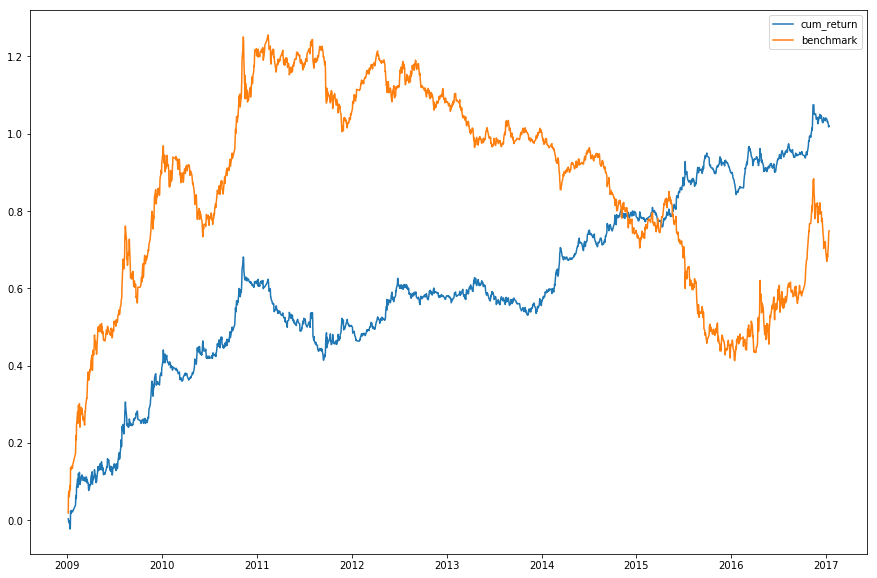

In [13]:
plt.figure(figsize=(15,10))
plt.plot(mixed_port['update_date'],mixed_port['cum_return'])
plt.plot(mixed_port['update_date'],mixed_port['benchmark'],label='benchmark')
plt.legend()

In [14]:
mixed_port['year']=mixed_port['update_date'].apply(lambda x: x.year)
each_year_return=mixed_port.groupby(['year']).portfolio_return.sum()

In [15]:
each_year_return

year
2009    0.393906
2010    0.218216
2011   -0.107877
2012    0.076221
2013   -0.025215
2014    0.230383
2015    0.113189
2016    0.141921
2017   -0.021003
Name: portfolio_return, dtype: float64

In [16]:
(np.mean(mixed_port['portfolio_return'])*252)/(np.std(mixed_port['portfolio_return'])*np.sqrt(252))

1.0795248214858177

In [17]:
np.mean(mixed_port['portfolio_return'])*252

0.1316470600825934

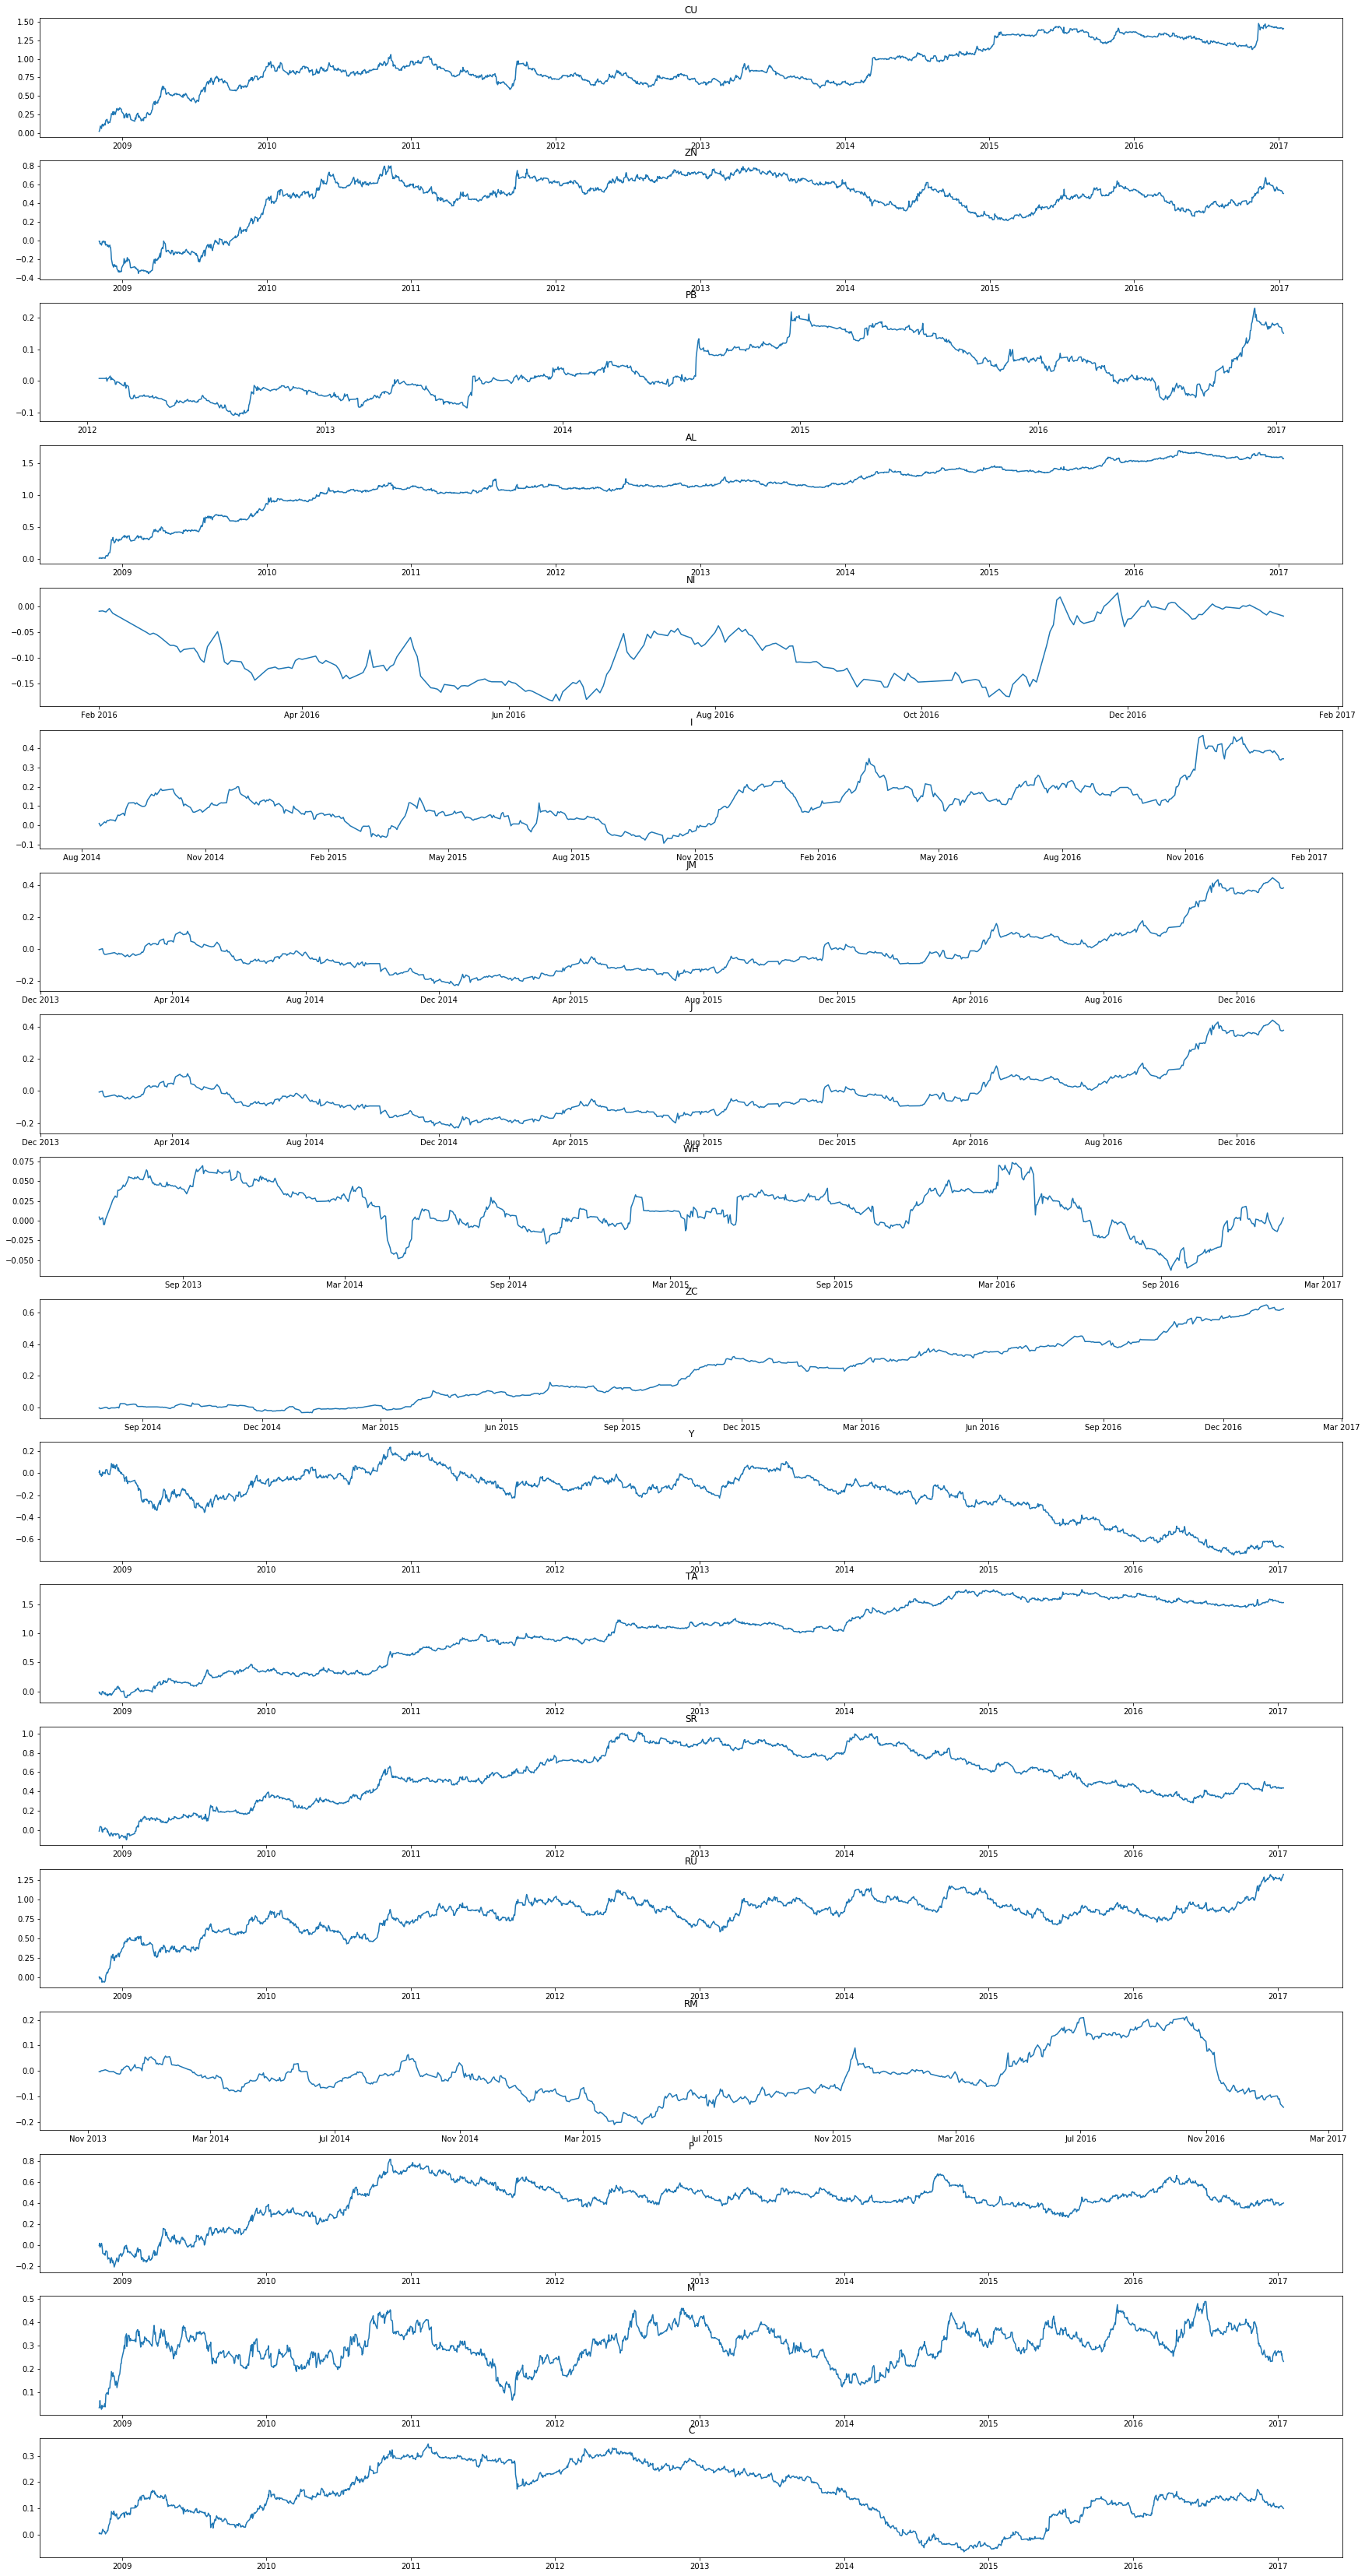

In [18]:
plt.figure(figsize=(30,60))
N=len(asset_pool)
i=1
for a in asset_pool:
    plt.subplot(N,1,i)
    tmp=execute(a)
    plt.plot(tmp['cum_return'])
    plt.title(a)
    i+=1

In [70]:
cu=pd.read_csv('/Users/liyuefan/Documents/gtja/CUFI_0112.csv',encoding='gbk')
cu['update_date']=pd.to_datetime(cu['update_date'])
cu.index=[cu['update_date']]

In [71]:
cu['close_yes']=cu['close'].shift(2)

In [72]:
close_yes=np.array(cu['close_yes'])

In [73]:
cu['sama_20']=sama(close_yes,50)

In [74]:
cu=cu.iloc[250:,:]

In [75]:
cu['sama_diff']=cu['close_yes']-cu['sama_20']

In [76]:
cu['dir']=cu['sama_diff'].apply(lambda x: 1 if x>0 else -1)

In [77]:
cu['rr']=np.log(cu['close'])

In [78]:
cu['rr']=cu['rr'].diff()

In [79]:
cu['daily_return']=cu['dir']*cu['rr']

In [80]:
# cu=cu[pd.to_datetime('2012-6-1'):pd.to_datetime('2014-01-01')]

In [81]:
cu['cum_return']=cu['daily_return'].cumsum()

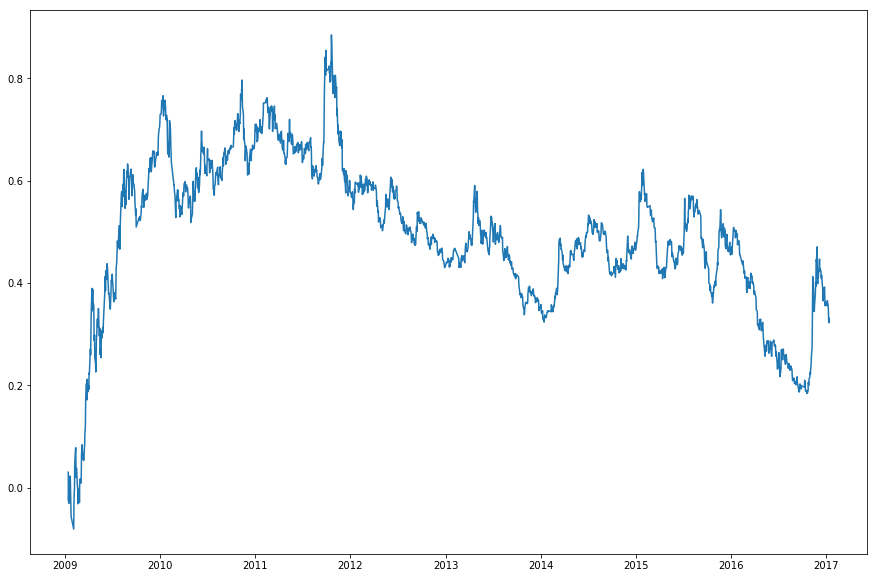

In [82]:
plt.figure(figsize=(15,10))
plt.plot(cu['cum_return'])

In [83]:
(252*np.mean(cu['daily_return'])-0.03)/(np.std(cu['daily_return'])*np.sqrt(252))

0.054919315288497916

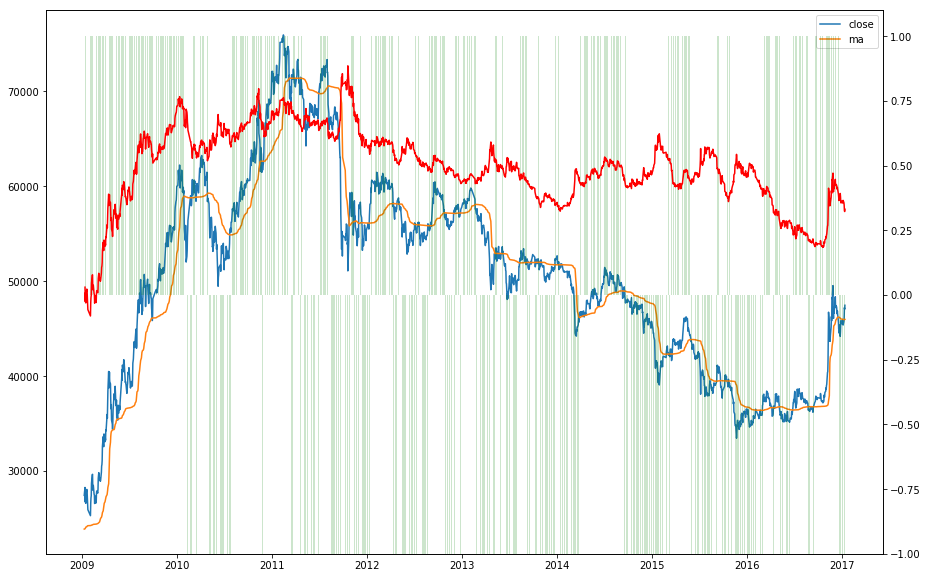

In [84]:
plt.figure(figsize=(15,10))
plt.plot(cu['close'],label='close')
plt.plot(cu['sama_20'],label='ma')
plt.legend()
ax2=plt.twinx()
ax2.bar(cu.index,cu['dir'],alpha=0.2,color='green');
ax2.plot(cu['cum_return'],color='red')
plt.show()

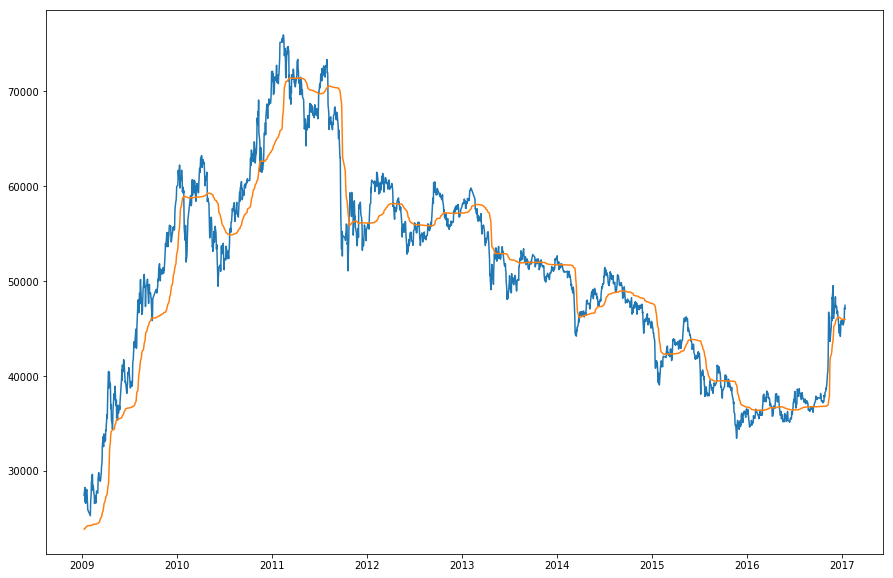

In [85]:
plt.figure(figsize=(15,10))
plt.plot(cu['close'],label='close')
plt.plot(cu['sama_20'],label='ma')

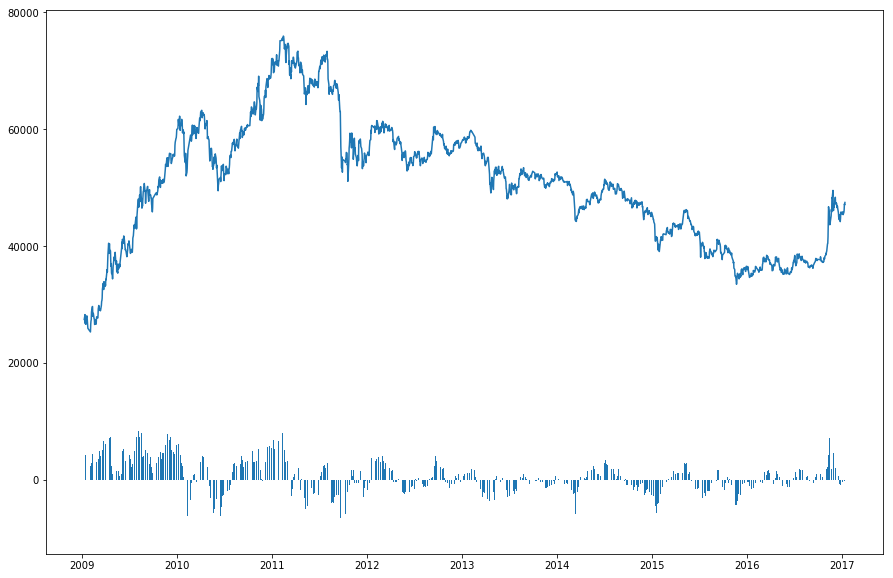

In [95]:
plt.figure(figsize=(15,10))
plt.bar(cu.index,cu['sama_diff']);
plt.plot(cu['close'])

In [104]:
cu['cum_sama_diff']=cu['sama_diff'].cumsum()

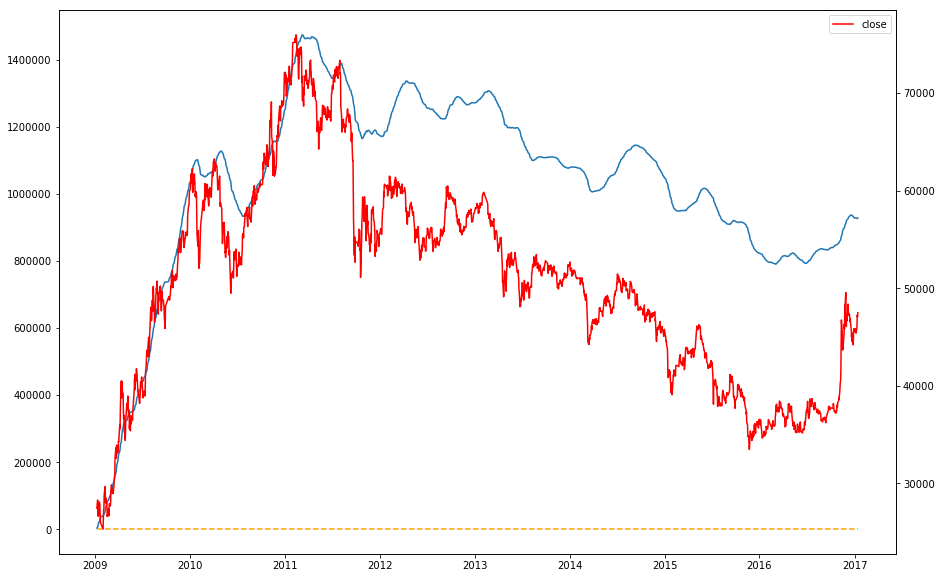

In [105]:
plt.figure(figsize=(15,10))
plt.plot(cu['cum_sama_diff'])
plt.hlines(0,min(cu.index),max(cu.index),linestyles='dashed',color='orange')
ax2=plt.twinx()
ax2.plot(cu['close'],label='close',color='red')
ax2.legend()

In [106]:
import scipy.stats as stats

In [107]:
close=np.array(cu['close'])
sama=np.array(cu['cum_sama_diff'])
corr,p=stats.pearsonr(close,sama)

In [108]:
corr

0.79218131865319763

In [109]:
p

0.0

In [110]:
cu['sama_diff_std']=pd.rolling_std(cu['sama_diff'],50)

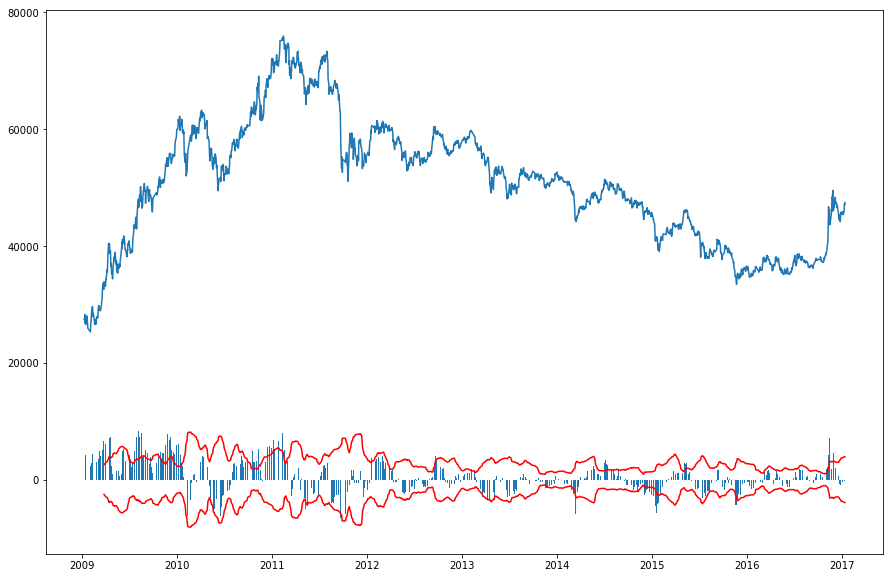

In [111]:
plt.figure(figsize=(15,10))
plt.bar(cu.index,cu['sama_diff']);
plt.plot(2*cu['sama_diff_std'],color='red');
plt.plot(-2*cu['sama_diff_std'],color='red')
plt.plot(cu['close'])